`f_` is the intended order to go through the notebooks if I forgot what I did in the future.

In [438]:
import sys
E9path = Path("C:/", "Users", "ken92", "Documents", "Studies", "E5", "simulation", "E9_simulations")
if str(E9path) not in sys.path:
    sys.path.insert(1, str(E9path))
from E9_fn import util

import util_thm
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import os

# Constant $N_{tot}$ and $S_{tot}$
Now I have a three-dimensional parameter space $(n_s, N_{tot}, S_{tot})$ for each interaction strength $V$. At each point in this parameter space, I can evaluate things like $s_s$, $V_{offset}$ and so on, possibly with interpolation. A constant $N_{tot}$ and $S_{tot}$ slice gives these parameters as a function of $n_s$ only.

It should be possible to invert $n_s$ and $V_{offset}$ if one wants to, and we know that this has to be a monotonic function. We can do this inversion after the constant $N, S$ slice.

## Reading data
Read all the files with the correct parameters to get all $n_s$. Only take the point with the desired $N_{tot}$ and $S_{tot}$ from each file.

In [467]:
V_list = np.array([-0.1, 0, 0.1, 0.3, 1.])
shift = -2
tp = 1.41421356237
L_subregion = 25
Stot = 3.
Ntot = 70
str_query = f"Stot == {Stot} & Ntot == {Ntot}"
str_query = f"Stot == {Stot} & Ntot == {Ntot} & beta >= 0"

In [468]:
df_invert_list = []
good_list = []
for i_V, V in enumerate(V_list):
    folder_name = f"ST_SL_I_L25_t1_tpsqrt2_shf{shift}_V{V}_chi64"
    if V == 0: folder_name = f"sawtooth_spinless_NI_L{L_subregion}"
    folder_path = Path(r"C:\Users\ken92\Documents\Studies\E5\simulation\E9_simulations\projects\flat_band_cooling\tenpy_results\invert_S_results",
                    folder_name)
    df_record = []
    for csv_path in folder_path.glob(f"*tp{tp}_shift{shift}_ns*.csv"):
        df_loaded = pd.read_csv(csv_path)
        df_filtered = df_loaded.query(str_query)
        if len(df_filtered) > 0: df_record.append(df_filtered)
    if len(df_record) == 0:
        continue
    else:
        df_invert_list.append(pd.concat(df_record))
        good_list.append(i_V)

V_list = V_list[good_list]

In [469]:
beta_allV = []
n_s_allV = []
mu_glob_allV = []
V_offset_allV = []
s2_s_allV = []
s2_r_allV = []
varsigma_allV = []
for df_invert in df_invert_list:
    beta_allV.append(df_invert["beta"].to_numpy(dtype=float))
    n_s_allV.append(df_invert["n_s"].to_numpy(dtype=float))
    mu_glob_allV.append(df_invert["mu_glob"].to_numpy(dtype=float))
    V_offset_allV.append(df_invert["V_offset"].to_numpy(dtype=float))
    s2_s_allV.append(df_invert["s2_s"].to_numpy(dtype=float))
    s2_r_allV.append(df_invert["s2_r"].to_numpy(dtype=float))
    varsigma_allV.append(df_invert["varsigma"].to_numpy(dtype=float))

## Some post processing
### Finding the minimum $s_s$
We ask: if we don't ask for a specific $n_s$, what is the $V_{offset}$ that gives us the lowest $s_s$?

In [470]:
argmin_s2_s_allV = [np.nanargmin(s2_s) for s2_s in s2_s_allV]

## Plots
### as $f(n_s)$
This is what I get directly from my algorithm.

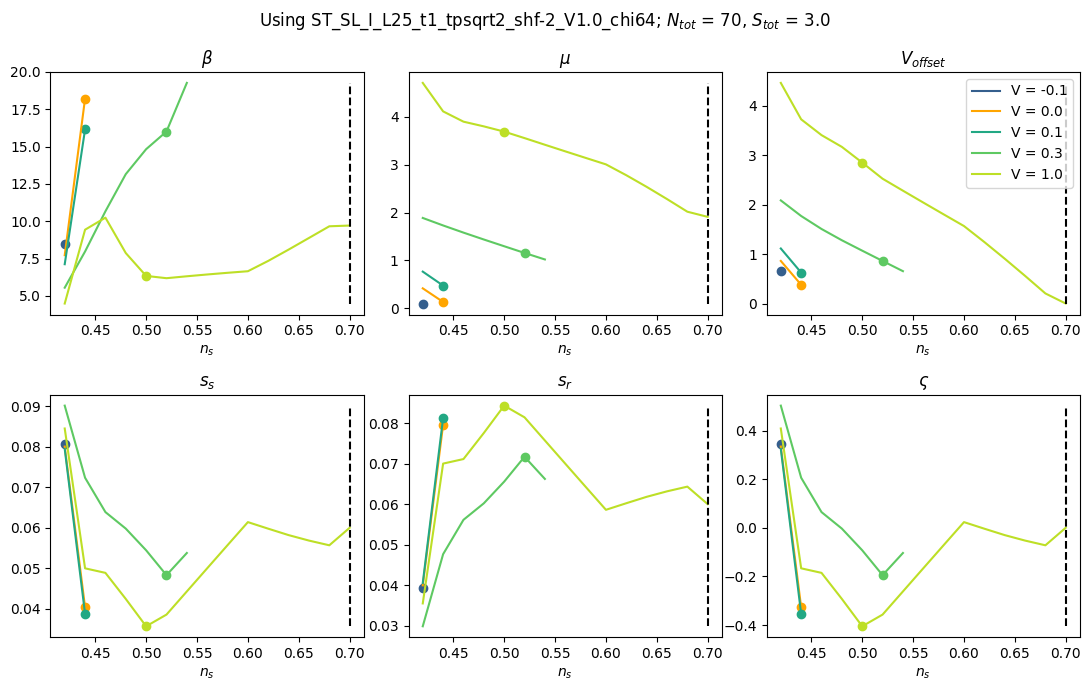

In [471]:
fig_ns, axes_ns = plt.subplots(2, 3, figsize = (11, 7))
for ax, vals_allV, str_label in zip(axes_ns.flatten(),
        [beta_allV, mu_glob_allV, V_offset_allV, s2_s_allV, s2_r_allV, varsigma_allV],
        [r"$\beta$", r"$\mu$", r"$V_{offset}$", r"$s_s$", r"$s_r$", r"$\varsigma$"]):
    for n_s, vals, V, i_min in zip(n_s_allV, vals_allV, V_list, argmin_s2_s_allV):
        c = util.get_color(V, V_list, crange = (0.3, 0.9))
        if V == 0: c = "orange"
        ax.plot(n_s, vals, color = c, label = f"V = {V}")
        ax.scatter(n_s[i_min], vals[i_min], color = c)
    ax.set_title(str_label)
    ax.set_xlabel(r"$n_s$")
    minval = min([np.nanmin(vals) for vals in vals_allV])
    maxval = max([np.nanmax(vals) for vals in vals_allV])
    ax.vlines(Ntot / 4 / L_subregion, minval, maxval, color = "black", ls = "--")
axes_ns.flatten()[2].legend()
fig_ns.suptitle(rf"Using {folder_name}; $N_{{tot}}$ = {Ntot}, $S_{{tot}}$ = {Stot}")
fig_ns.tight_layout(w_pad = 0.1)

### as $f(V_{offset})$
This is done by inverting $n_s$ and $V_{offset}$ (trivial code wise). These plot might be more natural for a fixed experiment setting.

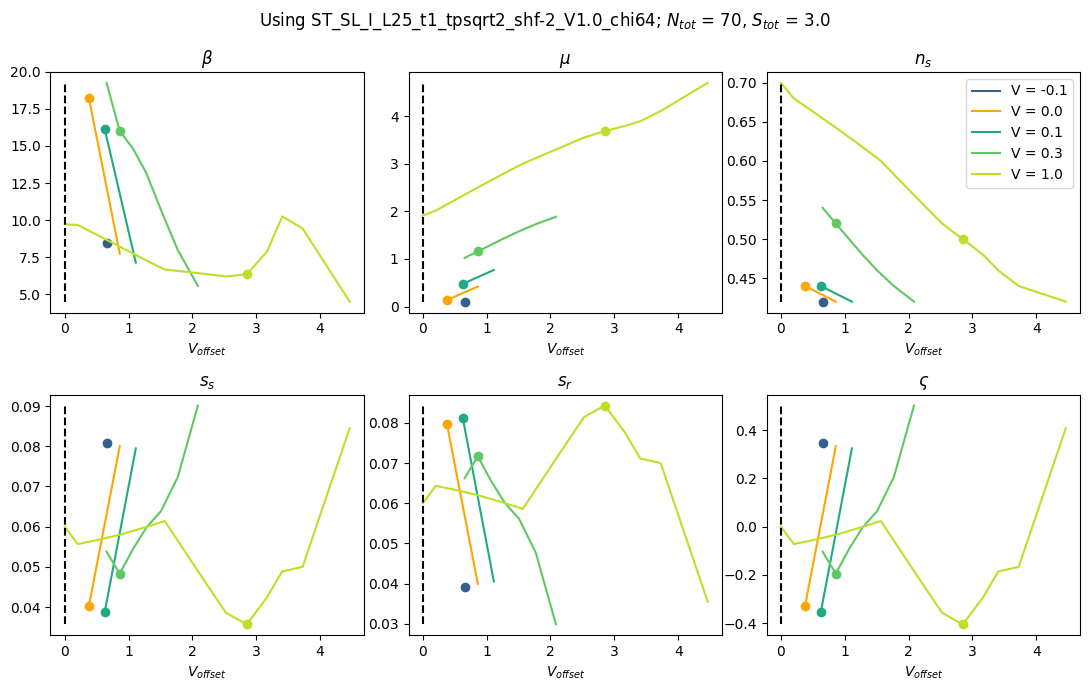

In [472]:
fig_ns, axes_ns = plt.subplots(2, 3, figsize = (11, 7))
for ax, vals_allV, str_label in zip(axes_ns.flatten(),
        [beta_allV, mu_glob_allV, n_s_allV, s2_s_allV, s2_r_allV, varsigma_allV],
        [r"$\beta$", r"$\mu$", r"$n_s$", r"$s_s$", r"$s_r$", r"$\varsigma$"]):
    for V_offset, vals, V, i_min in zip(V_offset_allV, vals_allV, V_list, argmin_s2_s_allV):
        c = util.get_color(V, V_list, crange = (0.3, 0.9))
        if V == 0: c = "orange"
        ax.plot(V_offset, vals, label = f"V = {V}",
                color = c)
        ax.scatter(V_offset[i_min], vals[i_min], color = c)
    ax.set_title(str_label)
    ax.set_xlabel(r"$V_{offset}$")
    minval = min([np.nanmin(vals) for vals in vals_allV])
    maxval = max([np.nanmax(vals) for vals in vals_allV])
    ax.vlines(0., minval, maxval, color = "black", ls = "--")
axes_ns.flatten()[2].legend()
fig_ns.suptitle(rf"Using {folder_name}; $N_{{tot}}$ = {Ntot}, $S_{{tot}}$ = {Stot}")
fig_ns.tight_layout(w_pad = 0.1)